In [1]:
import numpy as np 
import pandas as pd 
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from itertools import groupby
import random
from efficient_apriori import apriori
import ast
import pyfpgrowth
#from apyori import apriori
import csv 

In [2]:
train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv("orders.csv")

In [3]:
usersample = orders.loc[orders['eval_set']=='prior']

listofusers1 = usersample["user_id"].unique().tolist()
randIndex = random.sample(range(len(listofusers1)), 20000)
randIndex.sort()

listofusers = [listofusers1[i] for i in randIndex]
sampledorders = orders[orders['user_id'].isin(listofusers)]
listoforders1 = sampledorders["order_id"].unique().tolist()
#print(len(listoforders1))

In [4]:
sampledprior = prior[prior["order_id"].isin(listoforders1)]
#print(len(sampledprior))
sampledprior.head()

,order_id,product_id,add_to_cart_order,reordered
77,10,24852,1,1
78,10,4796,2,1
79,10,31717,3,0
80,10,47766,4,1
81,10,4605,5,1


Since the dataset is huge(32.4M rows), currently working on small portion of dataset by sampling 50000 users from the base of 200,000 users to achieve computations.

In [5]:
final_df = pd.merge(sampledprior,products, on = ['product_id','product_id'])
final_df = pd.merge(final_df,orders,on=['order_id','order_id'])
final_df = pd.merge(final_df,aisles,on=['aisle_id','aisle_id'])
final_df = pd.merge(final_df,departments, on=['department_id', 'department_id'])
final_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,10,24852,1,1,Banana,24,4,135442,prior,4,6,8,8.0,fresh fruits,produce
1,10,47766,4,1,Organic Avocado,24,4,135442,prior,4,6,8,8.0,fresh fruits,produce
2,10,21137,7,1,Organic Strawberries,24,4,135442,prior,4,6,8,8.0,fresh fruits,produce
3,22,24852,3,1,Banana,24,4,30822,prior,25,1,8,12.0,fresh fruits,produce
4,88,24852,6,1,Banana,24,4,102020,prior,4,0,11,7.0,fresh fruits,produce


## Quick Overview on products sold and uniqueness.

In [6]:
#Top 5 products
#Most sold product is banana
final_df['product_name'].value_counts()[0:5]

Banana                    44806
Bag of Organic Bananas    37519
Organic Strawberries      25282
Organic Baby Spinach      23213
Organic Hass Avocado      20125
Name: product_name, dtype: int64

In [7]:
#Top 5 aisles categories
final_df['aisle'].value_counts()[0:5]

fresh fruits                  351986
fresh vegetables              331584
packaged vegetables fruits    169574
yogurt                        139107
packaged cheese                94631
Name: aisle, dtype: int64

In [8]:
#Top 5 departments categories
final_df['department'].value_counts()[0:5]

produce       917770
dairy eggs    520597
snacks        282223
beverages     261001
frozen        217114
Name: department, dtype: int64

## Clustering 
Want to find a possible clusters among the different customers and substitute single user_id with the cluster to which they are assumed to belong. Hence creating a dataframe with all the purchases made by each user

In [9]:
customer_prod = pd.crosstab(final_df['user_id'], final_df['department'])
customer_prod.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
8,0,0,0,0,0,0,5,12,0,1,...,0,1,0,0,0,3,0,0,27,0
11,0,0,4,19,0,0,5,23,8,0,...,8,1,0,1,1,11,0,0,11,0
35,0,0,13,5,5,0,1,38,5,6,...,0,1,0,0,0,12,0,0,78,10
48,0,0,3,6,8,0,5,13,0,13,...,0,2,1,0,0,6,0,0,51,4
55,0,0,5,7,1,0,1,13,3,0,...,0,0,3,0,0,2,2,0,19,27


# Model 1 --> Clustering by reducing the no of dimensions, i.e, PCA

In [10]:
#Model 1
#Fitting it into 2 components
pca = PCA(n_components=2)
pca.fit(customer_prod)
sample_pca = pca.transform(customer_prod)
reduced_df = pd.DataFrame(sample_pca)
reduced_df.head()

,0,1
0,-30.068652,-14.421554
1,-34.026658,9.892674
2,30.389724,-15.050237
3,-5.847492,-19.559740
4,-29.260037,7.724988


In [11]:
tocluster = pd.DataFrame(reduced_df[[1,0]])
tocluster.head()

,1,0
0,-14.421554,-30.068652
1,9.892674,-34.026658
2,-15.050237,30.389724
3,-19.559740,-5.847492
4,7.724988,-29.260037


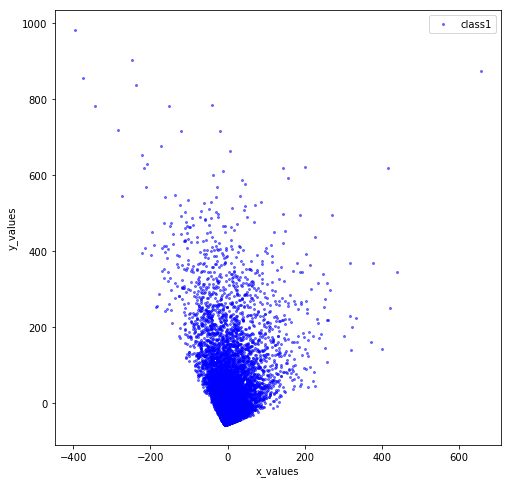

In [12]:
plt.figure(figsize=(8,8))
plt.plot(tocluster[1], tocluster[0], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [13]:
clusterer = KMeans(n_clusters=21,random_state=1).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

In [14]:
#Cluster centers
centers

array([[  -8.00078467,   -5.56136261],
       [  24.52678095,  176.00382893],
       [ -84.44144116,  454.50175425],
       [  -3.64922893,  -49.93599495],
       [  15.83148291,   36.06111019],
       [ 278.6646347 ,  243.06233107],
       [  26.6537138 ,  326.43889278],
       [  78.452405  ,   35.80798639],
       [ 141.66639479,  116.43600427],
       [  34.5883368 ,  101.7889041 ],
       [ -24.34459845,   69.62946911],
       [-217.02490288,  760.49121634],
       [ -22.08881542,   25.19752647],
       [ -87.46460457,  310.73964955],
       [  11.62601708,  -33.38925323],
       [ 110.8856834 ,  248.9346582 ],
       [  -9.34672836,  -31.30918297],
       [  32.8431942 ,   -6.6197356 ],
       [ -42.84431034,  126.73143657],
       [ -49.69893794,  217.38632372],
       [ 152.68339256,  538.17286586]])

## Cluster appearance

In [15]:
cluster_segregation = customer_prod.copy()
cluster_segregation['cluster'] = c_preds
cluster_segregation.head(10)

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
8,0,0,0,0,0,0,5,12,0,1,...,1,0,0,0,3,0,0,27,0,16
11,0,0,4,19,0,0,5,23,8,0,...,1,0,1,1,11,0,0,11,0,14
35,0,0,13,5,5,0,1,38,5,6,...,1,0,0,0,12,0,0,78,10,12
48,0,0,3,6,8,0,5,13,0,13,...,2,1,0,0,6,0,0,51,4,0
55,0,0,5,7,1,0,1,13,3,0,...,0,3,0,0,2,2,0,19,27,14
74,0,0,0,2,0,0,8,5,1,2,...,2,0,0,0,5,1,0,17,1,16
82,0,0,0,12,0,0,1,25,0,0,...,0,0,0,0,12,0,0,50,28,0
91,0,0,35,4,15,0,8,41,5,9,...,0,1,0,0,7,1,0,38,19,17
99,0,0,1,8,4,0,11,22,3,3,...,1,9,0,0,23,1,0,86,31,12


We have formed the clusters based on departments, i.e, 21 departments. Now we can look into the clust_segregation crosstab for interesting pattern.

In [16]:
#No of customers in each cluster
cluster_count = []
cluster_names = []
for number in range(len(departments)):
    cluster_count.append(len(cluster_segregation[cluster_segregation['cluster']==number]))
    cluster_names.append('C'+str(number))

cluster_info = pd.DataFrame(cluster_count, cluster_names)
cluster_info.columns = ['Count']
cluster_info.transpose()

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
Count,2236,288,88,6452,855,31,144,358,128,412,...,14,1010,114,2069,99,3325,960,420,266,23


### Top 5 departments for each cluster 

In [17]:
top_5 = []
colnames = []
for number in range(len(departments)):
    cluster = cluster_segregation[cluster_segregation['cluster']==number].drop('cluster',axis=1).mean()
    temp = cluster.sort_values(ascending=False)[0:5]
    top_5.append([temp.index[i] for i in range(5)])
    colnames.append('C'+str(number))
table = pd.DataFrame(top_5).transpose()
table.columns = colnames
table

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
0,produce,produce,produce,produce,produce,dairy eggs,produce,dairy eggs,dairy eggs,produce,...,produce,produce,produce,dairy eggs,produce,produce,dairy eggs,produce,produce,produce
1,dairy eggs,dairy eggs,dairy eggs,dairy eggs,dairy eggs,snacks,dairy eggs,snacks,snacks,dairy eggs,...,dairy eggs,dairy eggs,dairy eggs,beverages,dairy eggs,dairy eggs,beverages,dairy eggs,dairy eggs,dairy eggs
2,snacks,snacks,snacks,beverages,snacks,beverages,snacks,beverages,beverages,snacks,...,pantry,pantry,pantry,snacks,snacks,frozen,snacks,pantry,pantry,snacks
3,frozen,beverages,frozen,snacks,frozen,produce,beverages,produce,produce,beverages,...,snacks,frozen,snacks,produce,beverages,pantry,produce,snacks,snacks,beverages
4,beverages,frozen,pantry,frozen,beverages,deli,frozen,frozen,frozen,frozen,...,canned goods,snacks,frozen,frozen,frozen,beverages,frozen,frozen,frozen,frozen


Analysis of the clusters confirm the initial hypothesis that the products from the departments mentioned below are most generically bought by majority of customers:

1. Produce
2. Dairy Eggs
3. Snacks
4. Beverages
5. Frozen and pantry


In [18]:
#FP tree algorithm
class treeNode:
    def __init__(self, nameValue, numOccur, parentNode):
        self.name = nameValue
        self.count = numOccur
        self.nodeLink = None
        self.parent = parentNode      #needs to be updated
        self.children = {} 
    #increments the count variable with a given amount    
    def inc(self, numOccur):
        self.count += numOccur
    #display tree in text. Useful for debugging        
    def disp(self, ind=1):
        print ('  '*ind, self.name, ' ', self.count)
        for child in self.children.values():
            child.disp(ind+1)

def createTree(dataSet, minSup=1): #create FP-tree from dataset but don't mine
    headerTable = {}
    #go over dataSet twice
    for trans in dataSet:#first pass counts frequency of occurance
        for item in trans:
            headerTable[item] = headerTable.get(item, 0) + dataSet[trans]
    for k in list(headerTable):  #remove items not meeting minSup
        if headerTable[k] < minSup: 
            del(headerTable[k])
    freqItemSet = set(headerTable.keys())
    #print 'freqItemSet: ',freqItemSet
    if len(freqItemSet) == 0: return None, None  #if no items meet min support -->get out
    for k in headerTable:
        headerTable[k] = [headerTable[k], None] #reformat headerTable to use Node link 
    #print 'headerTable: ',headerTable
    retTree = treeNode('Null Set', 1, None) #create tree
    for tranSet, count in dataSet.items():  #go through dataset 2nd time
        localD = {}
        for item in tranSet:  #put transaction items in order
            if item in freqItemSet:
                localD[item] = headerTable[item][0]
        if len(localD) > 0:
            orderedItems = [v[0] for v in sorted(localD.items(), key=lambda p: p[1], reverse=True)]
            updateTree(orderedItems, retTree, headerTable, count)#populate tree with ordered freq itemset
    return retTree, headerTable #return tree and header table

def updateTree(items, inTree, headerTable, count):
    if items[0] in inTree.children:#check if orderedItems[0] in retTree.children
        inTree.children[items[0]].inc(count) #incrament count
    else:   #add items[0] to inTree.children
        inTree.children[items[0]] = treeNode(items[0], count, inTree)
        if headerTable[items[0]][1] == None: #update header table 
            headerTable[items[0]][1] = inTree.children[items[0]]
        else:
            updateHeader(headerTable[items[0]][1], inTree.children[items[0]])
    if len(items) > 1:#call updateTree() with remaining ordered items
        updateTree(items[1::], inTree.children[items[0]], headerTable, count)
        
def updateHeader(nodeToTest, targetNode):   #this version does not use recursion
    while (nodeToTest.nodeLink != None):    #Do not use recursion to traverse a linked list!
        nodeToTest = nodeToTest.nodeLink
    nodeToTest.nodeLink = targetNode
    
    
def createInitSet(dataSet):
    retDict = {}
    for trans in dataSet:
        retDict[frozenset(trans)] = 1
    return retDict


In [29]:
def recommend(li,ru,dicty,fq):
    result = []
    for jj, j in enumerate(li):
        rcmnd = []
        count =0
        for i in range(1, len(j)):
            flag = 0
            dummy = []
            for key,value in ru.items():
                if j[i] in key:
                    flag = 1
                    dummy.extend(list(value[0]))

            if flag == 0:
                rcmnd.append("#")
                for m in range(0,len(fq)):
                    if(defdict[fq[m][0]]==dicty[j[i]]):
                        count+=1
                        break
            else:
                rcmnd.append(list(set(dummy)))
                for k in dummy:
                    if(dicty[k]==dicty[j[i]]):
                        count+=1
                        break
        result.append(round((count/len(j))*100, 2))
    #print(result)
    return result


In [20]:
#Storing the clusters in csv files
for cluster_no in range(len(departments)):
    sample = cluster_segregation.loc[cluster_segregation['cluster'] == cluster_no]
    #userlist = sample.index.tolist()
    sample = sample.reset_index()
    sample.index.name = None
    sample.to_csv("cluster/C"+str(cluster_no)+".csv", sep=',' , index=False)

In [30]:
final_result = []
final_avg = []
for cluster_no in range(len(departments)):
    #for cluster_no in range(1):
    sample1 = pd.read_csv("cluster/C"+str(cluster_no)+".csv")
    userlist = sample1.user_id.tolist()
    
    df1 = orders[orders['user_id'].isin(userlist)]
    df2 = df1.loc[df1['eval_set'] == "prior"]
    
    
    ap = pd.merge(sampledprior,df2, on = ['order_id','order_id'])
    
    ordprod = ap[['order_id','product_id']]
    
    var_df = ordprod.groupby(['order_id'])['product_id'].agg(list).reset_index()
    big1 = var_df.product_id.values.tolist()
    big = [[str(x) for x in m] for m in big1] 
    f = open("nf"+str(cluster_no),"w")
    f.write(str(big1))
    f = open("new2/mf"+str(cluster_no), "w")
    for i in big:
        str1 = ','.join(str(e) for e in i)
        str1 = str1+","
        f.write(str1+"\n")

    fp = open("nf","r")
    contents = ast.literal_eval(fp.read())
    patterns = pyfpgrowth.find_frequent_patterns(contents, 5)
    fz = [k for k,v in patterns.items() if v==5]
    rules = pyfpgrowth.generate_association_rules(patterns, 0.001)
    
    
    f = open("dictionary/dict"+str(cluster_no)+".csv", "w")
    for key, value in rules.items():
        f.write("%s;%s\n"%(key, value))
        
        
    key = products.product_id.values.tolist()
    values = products.aisle_id.values.tolist()
    defdict = dict(zip(key, values))
    
    
    df0 = pd.merge(train, products, on = ['product_id', 'product_id'])
    final = pd.merge(df0, orders, on = ['order_id', 'order_id'])
    final = final[final['user_id'].isin(userlist)] 
    
    final1 = final.groupby(['order_id'])['product_id'].agg(list).reset_index()

    l = final1.product_id.values.tolist()
        
    res = recommend(l, rules, defdict, fz)
    final_avg.append(round(sum(res)/len(res), 2))
    final_result.append(res)

In [34]:
accuracy = round(sum(final_avg)/len(final_avg), 2)
accuracy

60.7

In [35]:
sampledprior.to_csv("sampledprior.csv", sep=',', index=False)

In [36]:
cluster_segregation.to_csv("cluster_segregation.csv", sep=',', index=False)